# Introduction

This notebook demonstrates the implementation of a Multi-layer Perceptron model using tensorflow library. The MNIST dataset is used for traini the model.

## Imports 
The libraries that are required to implement the model are imported

In [1]:
import numpy as np   # scientific computing library
import tensorflow as tf  # library to implement ML
import matplotlib.pyplot as plt # to plot graphs 

In [2]:
print 'Library versions used.'
print 'Numpy :{} \nTensorflow :{}'.format(np.version.version, tf.__version__)

Library versions used.
Numpy :1.13.1 
Tensorflow :1.2.1


## Data  download
The MNIST dataset is downloaded from the tensorflow website in one_hot vector format

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


The MNIST is split into three part: 55,000 data points of training data (mnist.train), 10,000 points of test data (mnist.test), and 5,000 points of validation data (mnist.validation).

In [4]:
print 'Data Size'
print 'Training Data \t:', len(data.train.labels)
print 'validation Data :', len(data.validation.labels)
print 'Testing Data \t:', len(data.test.labels)

Data Size
Training Data 	: 55000
validation Data : 5000
Testing Data 	: 10000


## Example of training data
Each image in the MNIST dataset is a 28x28 grey-scale image which is flattened into a single a vector of 784 numbers.

In [5]:
print 'Training image vector size :', len(data.train.images[0]) #Size of a training image

Training image vector size : 784


Each image has the possibility of being any of the 10 numbers from 0-9. Thus yielding the labels of the image to be a one_hot vector denoting that particular number present in the image.

In [6]:
print 'Number of labels :', len(data.train.labels[0])
print 'Example of a label :', data.train.labels[0]

Number of labels : 10
Example of a label : [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]


We can see that in the above example the number in the image correspondes to 7 since the entry of index 6 (index starts from 0) is set to 1.

The labels of the input images are required in single values as well which would help us in further functions like for calculating accuracy or in plotting the true lable with image.

In [7]:
data.validation.cls = np.array([label.argmax() for label in data.validation.labels])
data.test.cls = np.array([label.argmax() for label in data.test.labels])

## Data dimensions
The data dimensions will be used in different places in the code and hard-coding them in each place is not a good practice and makes debugging harder. So we define them as variables and use the variable name in othe rlocation

In [8]:
image_size = 28
image_size_flatten = image_size * image_size
num_labels = 10

## Visualizing the data as image
Lets buid a helper function that uses the training vector to reconstruct the 28x28 image. For easier implementation we make sure that we always pass 9 images to the function.

In [9]:
def plot_image(images, labels):  # we pass the images and the corresponding labels to the function to plot
    assert len(images) == len(labels) #verify that the same length of images and labels are passed on
    
    fig, axes = plt.subplots(3, 3)  #create a subplots in 3 rows and 3 colums since we plot for 9 images
    fig.subplots_adjust(hspace=0.3, wspace=0.3) # provide spacing between the subplots
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(image_size,image_size), cmap='binary') # plot the i_th image
        
        # Remove the ticks in the axes
        ax.set_xticks([])
        ax.set_yticks([])
        
        #Print the true label of the image
        xlabel = "True: {}".format(np.argmax(labels[i]))
        ax.set_xlabel(xlabel)
        
    plt.show()

## Let's plot the first 9 images in the dataset and check

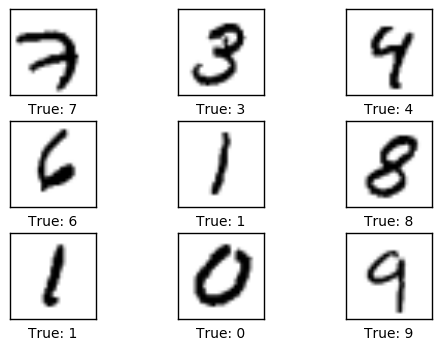

In [10]:
plot_image(data.train.images[0:9], data.train.labels[0:9])

## Tensorflow
Now we have our data, we shall build the computational graph in tensorflow for the learning model.
First thing is to define the placeholders that act as gateway to pass the input to the computational graph.

## Placeholder for the input
Defining this makes us to pass the input images to the tensorflow graph. the datatype is set to float32 and the shape is [None, image_size] which means we can pass arbitraty number of images with each image containting a vector of size image_size.

In [11]:
x = tf.placeholder(tf.float32, [None, image_size_flatten])

We define two other place holders y and y_cls through which we can input the labels of the image. y is defined to have a datatype float32 with shape [None, num_labels] since each image labels is a one hot vector of size num_labels (i.e 10 in our case). and y_cls is defined to have a datatype int16 with shape [None] since it holds the true class of each image as number.

In [12]:
y_true = tf.placeholder(tf.float32, [None, num_labels])
y_true_cls = tf.placeholder(tf.int64, [None])

## Model

The architecture of a CNN can be seen below.
![](http://personal.ie.cuhk.edu.hk/~ccloy/project_target_code/images/fig3.png)

A CNN consists of 3 important functions namely, convolutions, pooling and fully connected layer.

### Convolutions 
Convolutions is the core of the ConvNets that helps to extract the features from the input image. The input image is represented as a matrix of pixel. In this case as the input considered is a greyscaled image, the matrix values is either 0 or 1. The operation can be seen as a sliding window function applied to the matrix. The sliding window function is called a filter which is a matrix. Here we use a 5x5 filter to multiply its values element-wise with the original matrix, then sum them up to get the convolution. To get the convolution for the whole matrix we do this for each element in the input matrix by sliding the filter over it. The result outcome is called the convolved feature or feature map. Applying filters of different sizes we can detect different features of an image like, curves, edges etc.

### Pooling
![](http://cs231n.github.io/assets/cnn/maxpool.jpeg)
Pooling Pooling also known as downsampling or subsampling reduces the dimensionality of each feature map but retaining most of the important information from it. The most commonly used pooling operation is max. For pooling operation we define a window (2x2 is used in figure 3.9) and output the maximum element from the rectified feature map within that window. The other operation like average or min or sum can also be used depending on the task. Pooling has the property of providing a fixed size output matrix irrespective of the size of filter used for convolution which is required for classification.

### Fully connected layer
Fully connected layer is a multi layer perceptron where a layer has connections from all activations in the previous layer. The high level features that are detected by the previous layers of the ConvNet is used here to classify the input into various classes.

The above architecture in the image of CNN consists of 3 convolutional layer with pooling and 2 fully connected layer and a output layer. We implement a CNN with 2 convolutional layer with pooling and 1 fully connected layer and a output layer

In [13]:
class ConvLayer(object):
    def __init__(self, inpt, filter_size, num_input_channels, num_filters, strides=(1,1,1,1), 
                 padding='SAME', activation=tf.nn.sigmoid):
        self.input = inpt
        
        #since the filter is a square matrix 
        filter_shape = [filter_size, filter_size, num_input_channels, num_filters]
        
        # weights for the filters 
        self.W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), dtype=tf.float32)
        #Read the stackexchange page for using truncated_normal to initalize the weights
        #https://stats.stackexchange.com/questions/228670/what-is-the-benefit-of-the-truncated-normal-distribution-in-initializing-weights
        
        # bias for the filters (one for each filter)
        self.b = tf.Variable(tf.truncated_normal(filter_shape[-1:], stddev=0.1), dtype=tf.float32)
        
        # perform convolution operation
        # the strides denote how the filter is moved over the input.
        conv_output = tf.nn.conv2d(self.input, filter=self.W, strides=strides, padding=padding)
        conv_output = conv_output + self.b
        
        #perform activation function
        self.output = activation(conv_output) if activation is not None else conv_output
        
        self.params = [self.W, self.b]       

In [14]:
class FlattenLayer(object):
    def __init__(self, inpt, shape):
        self.input = inpt
        
        #flatten a tensor to a single dimension
        self.output = tf.reshape(self.input, shape=shape)

In [15]:
class MaxPoolLayer(object):
    def __init__(self, inpt, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1), padding="SAME"):
        self.input = inpt
        # perform maxpooling based on the pool window(ksize) and the stride it has to move over the input
        self.output = tf.nn.max_pool(self.input, ksize=ksize, strides=strides, padding=padding)

There is one other function called dropout which is a method to prevent overfitting of data in neural networks. It drop's out certain units in the input based on the probability it is set to. By performing this operation the network can better model the probability of the data and perform better on unseen data. The droput is applied only during training and applying it during testing will result in poor performance as the model cannot use all the extracted features for prediction. So, while training the dropout should be set between 0 and 1 and for testing it should be set to 1. Setting 1 mean that we want the model to keep all the extracted features.

In [16]:
class DropoutLayer(object):
    def __init__(self, inpt):
        self.keep_prob = tf.placeholder(tf.float32)
        self.input = inpt
        
        # apply dropout
        self.output = tf.nn.dropout(self.input, keep_prob=self.keep_prob)

In [17]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         # There are 36 of these filters.

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

The convolutions require the input to be encoded as a 4-dim tensor. So we reshape the input image to 4D of shape [num_input_images, img_size, img_size, num_channels]. The num_input images is inferred automatically by placing -1.

In [18]:
inpt = tf.reshape(x, shape=[-1, image_size, image_size, num_channels])

First convolution layer followed by pooling layer

In [19]:
layer0_conv = ConvLayer(inpt, filter_size=filter_size1, num_input_channels = num_channels,
                        num_filters=num_filters1, strides=[1, 1, 1, 1],
                        activation=tf.nn.relu, padding='SAME')
# This is 2x2 max-pooling, which means that we consider 2x2 windows and select the largest value
# in each window. Then we move 2 pixels to the next window.
layer0_pool = MaxPoolLayer(layer0_conv.output, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1])

Second convolution layer followed by pooling layer

In [20]:
layer1_conv = ConvLayer(layer0_pool.output, filter_size=filter_size2, num_input_channels = num_filters1,
                        num_filters=num_filters2, strides=[1, 1, 1, 1], 
                        activation=tf.nn.relu, padding="SAME")
# This is 2x2 max-pooling, which means that we consider 2x2 windows and select the largest value
# in each window. Then we move 2 pixels to the next window.
layer1_pool = MaxPoolLayer(layer1_conv.output, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1])

We need to flatten the 4D tensor to a single dimension, to pass the values to fully connected layer.

In [21]:
#get the number of feature extracted by convolution layers
num_features = layer1_pool.output.get_shape()[1:4].num_elements()

#flatten to the number_of_features extracted by convolution layers
layer2_flatten = FlattenLayer(layer1_pool.output, shape=[-1, num_features]) 

#apply dropout to the flattened tensor.
layer2_dropout = DropoutLayer(layer2_flatten.output)

Lets create a fully connected layers with 128 neurons with relu activation function.

In [22]:
fc_size = 128
weights_fc = tf.get_variable('fc_w', [num_features, fc_size], tf.float32)
biases_fc = tf.get_variable('fc_b', [fc_size], tf.float32)
fc_output = tf.nn.relu(tf.matmul(layer2_dropout.output, weights_fc) + biases_fc)

The output of fully connected layer is passed onto the output layer which has neurons equal to the number of possible output labels.

In [23]:
weights_output = tf.get_variable('fc2_w', [fc_size, num_labels], tf.float32)
biases_output = tf.get_variable('fc2_b', [num_labels], tf.float32)
output = tf.matmul(fc_output, weights_output) + biases_output

The softmax function is then applied to the output score to predict the probabilities for each class.
The predicted label can be calculated by just looking at the index of the value with maximum probability.

In [24]:
y_pred = tf.nn.softmax(output)
y_pred_cls = tf.argmax(y_pred, dimension=1)

Now that we predicted some output for a given image, we need to tell the model the error it has made compared to the original label. This is done by the cross_entropy operation which calculates the error made in each image prediction.

In [25]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=y_true)

To optimize the model's variables we need a single scalar value which can be done by just taking the mean of all of all values. The reduce_mean function performs this operation and outputs a single scalar value

In [26]:
cost = tf.reduce_mean(cross_entropy)

## Optimizer
Now that we have the error calculated, we need to optimize the model variable's according to the error such that the objective is to minimize the error. Various optimizers have been proposed iin tensorflow but here we use "AdamOptimizer" with a learning_rate of 0.001.

In [27]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

## Accuracy measure
we define the below measures so that we can measure how well our model performs. The tf.equal function compares the inputs and returns a boolean tensor saying if the values in both inputs passed are equal or not. The reduce_mean function then calculates the mean of all values in the tensor giving us the exact fraction(0 to 1) of correct prediction.

In [28]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Training
Now that we have everything setup lets train the model.
To execute the tensorflow graph we need to create a session initially and then the variables of the model are initialied before we start to train the model

In [29]:
session = tf.Session()
session.run(tf.global_variables_initializer())

Since the input is of over 50k images, inputting them in a single go to the model will take considerable resources and also calculating the gradient of the model takes long time. So instead we pass input as batches of images.
And the more the model go over the input it can learn to better classify the image. The epoch variable denotes the number of times the complete dataset must be passed on to the model for learning. Having a higher epoch would overfit the model as well so we always need to check the accuracy on the validation dataset to check which model performs better.

In [30]:
batch_size = 64
epoch = 10

## Saving model
Let's define the path to save the best model while training.

In [31]:
# path to save the model
save_path = 'Checkpoints/model'

# create an object for the Saver function in tensorflow which we will use to save the model
saver = tf.train.Saver()

Let's train the model. The training is written as a function so we can later call this function to train the model.

In [32]:
import math
def train(epoch=10, batch_size=64):
    # calculate the total number of batches in the input dataset. 
    # This will give us a float value but the value is rounded to the higher integer.
    total_batch = math.ceil(float(len(data.train.images))/batch_size) 
    print '------------------TRAINING------------------'
    for i in range(epoch):           # number of times to pass over the dataset for training        
        avg_cost = 0
        
        # pass each batch to the model for learning
        for j in range(int(total_batch)):    #since total_batch is in float we convert to int
            # get the next batch of input data
            x_batch, y_batch = data.train.next_batch(batch_size)
            
            # denote the data that needs to passes onto the placeholders defined in the tensorflow graph
            # we also need to denote the dropout probability while training.
            feed_dict = {x: x_batch, y_true: y_batch, layer2_dropout.keep_prob:0.5}
            
            # run the optimizer using this batch of data
            _, c = session.run([optimizer, cost], feed_dict)            
            
            # Compute average loss
            avg_cost += c / total_batch
            
        print 'Epoch :{0} completed. Error :{1}'.format(i+1, avg_cost)
    print '-------------TRAINING COMPLETED-------------'
    
    #Let's save the trained model
    saver.save(session, save_path)

We implement a helper function that calls the above defined accuracy measure and prints the accuracy of the model

In [33]:
def get_accuracy(datatype='test'):  
    # datatype parameter denotes if the accuracy is to be 
    # calculated on test or validation data
    
    # pass the test data to the placeholders as input since we require the accuracy on test data
    if datatype == 'test':
        feed_dict_test = {x: data.test.images,
                      y_true: data.test.labels,
                      y_true_cls: data.test.cls,
                      layer2_dropout.keep_prob: 1.0}
    else: 
        feed_dict_test = {x: data.validation.images,
                      y_true: data.validation.labels,
                      y_true_cls: data.validation.cls,
                      layer2_dropout.keep_prob: 1.0}    
    # Compute the accuracy and cost on the test data
    acc, c = session.run([accuracy, cost], feed_dict=feed_dict_test)
        
    return round((acc*100),1), c

Let's check the accuracy of the initial model without any training done.

In [34]:
acc, c = get_accuracy('test')
print 'Accuracy of inital model :{0}%. Cost :{1}'.format(acc, c)

Accuracy of inital model :11.3%. Cost :2.36104536057


Now let's train the model for 20 epochs and check the accuracy of it.

In [35]:
train(epoch=10)
acc, c = get_accuracy('test')
print 'Accuracy of trained model :{0}%. Cost :{1}'.format(acc, c)

------------------TRAINING------------------
Epoch :1 completed. Error :0.211866000023
Epoch :2 completed. Error :0.0707437781593
Epoch :3 completed. Error :0.0528359081321
Epoch :4 completed. Error :0.0430821562398
Epoch :5 completed. Error :0.0376102932055
Epoch :6 completed. Error :0.0345284996746
Epoch :7 completed. Error :0.0291672784671
Epoch :8 completed. Error :0.0262636615834
Epoch :9 completed. Error :0.0250504636678
Epoch :10 completed. Error :0.0221681982216
-------------TRAINING COMPLETED-------------
Accuracy of trained model :99.1%. Cost :0.02518725954


## Visualizing the weigths and layers

Visualizing the weights of the convolutional filter, can help us understand the functioning of each filter.

In [45]:
### Function to plot the weights of convolutional layer

In [37]:
import math
def plot_conv_weights(weights, input_channel=0):
    
    # get the weights
    W = session.run(weights)
    
    #find the minimum and maximum of those weigths
    W_min = np.min(W)
    W_max = np.max(W)
    
    #get the number of filters used in that layer
    num_filters = W.shape[3]

    #plot number of grids equalling to display all the filters
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        #for each filter plot the image.
        if i<num_filters:
            img = W[:, :, input_channel, i]
            ax.imshow(img, vmin=W_min, vmax=W_max,
                      interpolation='nearest', cmap='seismic')
        #remove the ticks from the image
        ax.set_xticks([])
        ax.set_yticks([])
    #display the image
    plt.show()

### Function to plot the output of a convolution layer

In [38]:
def plot_conv_layer(layer, image):
    # we need to pass the image as input to get the layer output
    feed_dict = {x: [image]}
    
    # run the session and get the layer values
    layer = session.run(layer, feed_dict=feed_dict)
    
    #number of filters used in that layer
    num_filters = layer.shape[3]
    
    #plot number of grids equalling to display all the filters
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    fig, axes = plt.subplots(num_grids, num_grids)
    for i, ax in enumerate(axes.flat):
        #for each filter plot the image.
        if i<num_filters:
            img = layer[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
        #remove the ticks from the image
        ax.set_xticks([])
        ax.set_yticks([])
    #display the image
    plt.show()

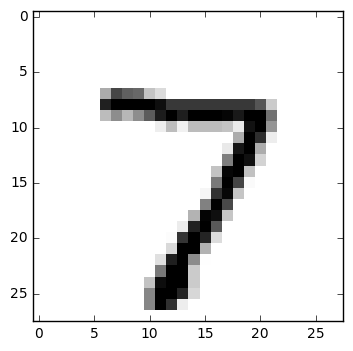

In [39]:
#sample image for which we want to infer how the convolution layer behaves
image = data.test.images[0]
plt.imshow(image.reshape(image_size,image_size), interpolation='nearest', cmap='binary')
plt.show()

Let's visualize the output of layer0 after the pooling operation and the weights of layer0.

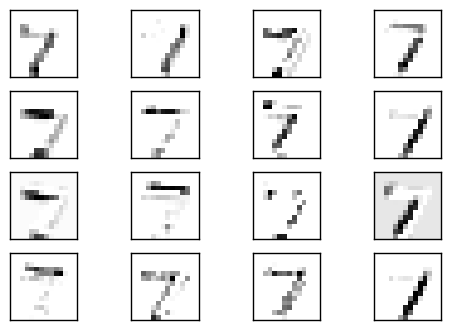

In [40]:
plot_conv_layer(layer0_pool.output, image=image)

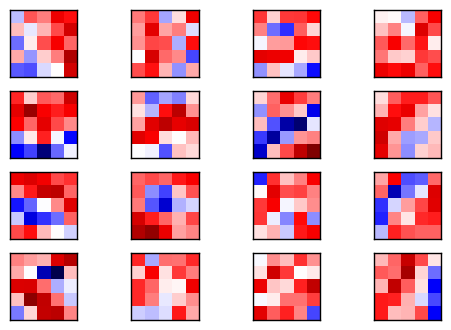

In [41]:
plot_conv_weights(layer0_conv.W, input_channel=0)

Let's visualize the output of layer1 after the pooling operation and the weights of layer1.

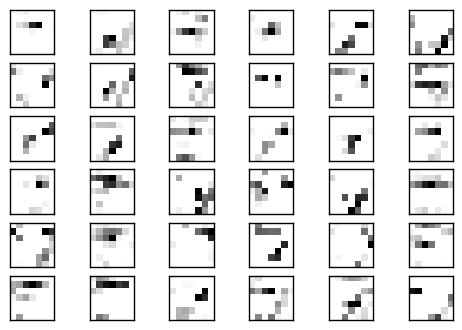

In [42]:
plot_conv_layer(layer1_pool.output, image=image)

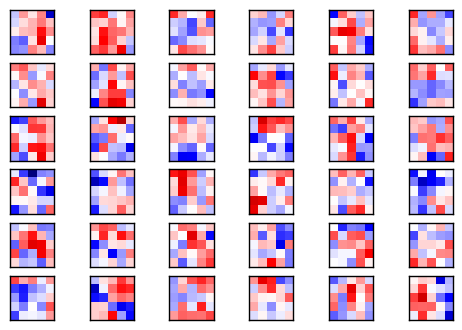

In [43]:
plot_conv_weights(layer1_conv.W, input_channel=0)

layer0 has only one input channel, but layer1 has 16 input channels, so we can make 15 other such plots for weights and layer visualizations for layer1.

## Close the tensorlfow session

In [44]:
session.close()